Plot T-S diagrams and platform positions using the data from CMEMS.<br>
For Argo floats, the pressure has to be transformed to depth.

In [27]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import glob
import os
import seawater
import cmocean
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
import logging
%matplotlib inline

# Configurations

In [28]:
figdir = "/data_local/DataOceano/CMEMS/INSITU_GLO_NRT_OBSERVATIONS_013_030/monthly/profiler-glider/figures"
datadir = "/data_local/DataOceano/CMEMS/INSITU_GLO_NRT_OBSERVATIONS_013_030/monthly/profiler-glider"
#datadir = "/data_local/DataOceano/CMEMS/INSITU_GLO_NRT_OBSERVATIONS_013_030/monthly/201507/vessel/"
#figdir = "/data_local/DataOceano/CMEMS/INSITU_GLO_NRT_OBSERVATIONS_013_030/monthly/201507/vessel/figure"

dlon, dlat = 2., 1.
tmin, tmax, smin, smax = -2., 28., 30., 40.

## Logging

In [29]:
logdir = './log/'
if not(os.path.exists(logdir)):
    os.mkdir(logdir)
logfilename = os.path.join(logdir, 'plot_TS_diagram_all.log')

# create logger 
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)
# create file handler which logs even debug messages
fh = logging.FileHandler(logfilename)
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.CRITICAL)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
logger.info('+++ Start new run +++')

# Functions to read and plot

In [18]:
def read_variables(datafiles):
    '''
    Extract the temperature, salinity and coordinates from a netCDF file.
    Convert the pressure to depth if necessary.
    Keep only the good values (based on quality flags).
    '''
    logger = logging.getLogger(__name__)
    with netCDF4.Dataset(datafiles) as nc:
        time = nc.variables['TIME'][:]
        time_units = nc.variables['TIME'].units
        lon = nc.variables['LONGITUDE'][:]
        lat = nc.variables['LATITUDE'][:]
        try:
            pressure = nc.variables['PRES'][:]
            depth = seawater.eos80.dpth(pressure, np.tile(lat, (pressure.shape[1], 1)).T)
            logger.info('Converting pressure to depth')
        except KeyError:
            depth = nc.variables['DEPH'][:]
        
        try:
            temp = nc.variables['TEMP'][:]
            temp_qc = nc.variables['TEMP_QC'][:]
        except KeyError:
            logger.warning('Temperature not available in the profiles')
            temp = np.nan * np.ones_like(depth)
            temp_qc = np.nan * np.ones_like(temp)
        try: 
            psal = nc.variables['PSAL'][:]
            psal_qc = nc.variables['PSAL_QC'][:]
        except KeyError:
            logger.warning('Salinity not available in the profiles')
            psal = np.nan * np.ones_like(temp)
            psal_qc = np.nan * np.ones_like(temp)
    temp, psal = apply_qc_variables(temp, temp_qc, psal, psal_qc)
    return time, time_units, lon, lat, depth, temp, psal

In [6]:
def convert_time(time, time_units):
    '''
    Convert time to dates and change the vector to a 2D array.
    '''
    dates = netCDF4.num2date(time, time_units)
    datesarray = np.tile(dates, (pressure.shape[1], 1)).T
    return datesarray

In [7]:
def get_init_final_dates(datesarray):
    '''
    Compute initial and final dates
    '''
    dayinit = datesarray[0, 0].strftime('%d %B %Y')
    dayend = datesarray[-1, 0].strftime('%d %B %Y')
    return dayinit, dayend

In [8]:
def apply_qc_variables(temp, temp_qc, psal, psal_qc):
    '''
    Apply the quality flags (we keep only the good values)
    '''
    temp = np.ma.masked_where(temp_qc != 1, temp)
    psal = np.ma.masked_where(psal_qc != 1, psal)
    # chloro = np.ma.masked_where(chloro_qc > 3., chloro)
    return temp, psal

In [9]:
def compute_density4plot(tmin, tmax, smin, smax):
    '''
    Generate temperature and salinity vectors, and an 2D array of,
    given temperature and salinity ranges. 
    The density is evaluated using the EOS80.
    '''
    ds, dt = 0.05, 0.1
    tvec = np.arange(tmin, tmax, dt)
    svec = np.arange(smin, smax, ds)
    ssvec, ttvec = np.meshgrid(svec, tvec)
    density = seawater.eos80.dens0(ssvec, ttvec) - 1000.0
    return svec, tvec, density
    

In [39]:
def plot_TS(temp, psal, depth, svec, tvec, density, title, m, figname):
    '''
    Create the T-S diagram
    '''
    fig = plt.figure(figsize=(15, 15))
    rcParams.update({'font.size': 18})
    plt.scatter(psal, temp, s=5, c=depth, vmin=10., vmax=1000.,
               edgecolor='None', cmap=plt.cm.plasma)
    cbar = plt.colorbar(extend='max')
    plt.xlabel('Salinity', fontsize=18)
    plt.ylabel('Temperature\n($^{\circ}$C)', rotation=0, ha='right', fontsize=18)
    cont = plt.contour(svec, tvec, density, levels=np.arange(22., 32., 1.), 
                       colors='.65', linestyles='dashed', lineswidth=0.5)
    plt.clabel(cont,inline=True, fmt='%1.1f')
    plt.xlim(smin, smax)
    plt.ylim(tmin, tmax)
    cbar.set_label('Depth\n(m)', rotation=0, ha='left')
    plt.grid(color="0.6")

    # Add an inset showing the positions of the platform
    inset=plt.axes([0.135, 0.625, 0.3, 0.35])
    lon2plot, lat2plot = m(lon, lat)
    m.drawmapboundary(color='w')
    m.plot(lon2plot, lat2plot, 'ro', ms=2, markeredgecolor='r')
    #m.drawcoastlines(linewidth=0.25)
    m.drawlsmask(land_color='0.4', ocean_color='0.9', lakes=False)
    plt.title(title, fontsize=20)
    plt.savefig(figname, dpi=150)
    plt.show()
    plt.close()

In [11]:
def plot_trajectory(lon, lat, dlon, dlat, figbasename, dayinit, dayend):
    
    coordinates = np.floor(lon.min()), np.ceil(lon.max()), np.floor(lat.min()), np.ceil(lat.max())
    
    m = Basemap(projection='merc', llcrnrlon=coordinates[0], llcrnrlat=coordinates[2],
                    urcrnrlon=coordinates[1], urcrnrlat=coordinates[3],
                    lat_ts=0.5 * (coordinates[2] + coordinates[3]), resolution='i')
    figname = figbasename + '_trajectory'
    fig = plt.figure(figsize=(12, 12))

    lonproj, latproj = m(lon, lat)
    m.plot(lonproj, latproj, 'ko-')
    m.plot(lonproj[0], latproj[0], '>g', markersize=15, zorder=2, label='Starting point')
    m.plot(lonproj[-1], latproj[-1], 'sr', markersize=15, zorder=2, label='Final point')
    m.drawparallels(np.arange(round(coordinates[2]), coordinates[3], dlat), linewidth=0.2,
                    labels=[1, 0, 0, 0], fontname='Times New Roman', fontsize=16, zorder=1)
    m.drawmeridians(np.arange(round(coordinates[0]), coordinates[1], dlon), linewidth=0.2,
                    labels=[0, 0, 0, 1], fontname='Times New Roman', fontsize=16, zorder=1)
    m.drawcoastlines()
    plt.legend(numpoints=1, fontsize=16, loc=2)
    plt.title('Trajectory from %s to %s' %(dayinit, dayend), fontsize=24)
    plt.savefig(os.path.join(figdir, figname), dpi=300)
    plt.close()

# Main loop

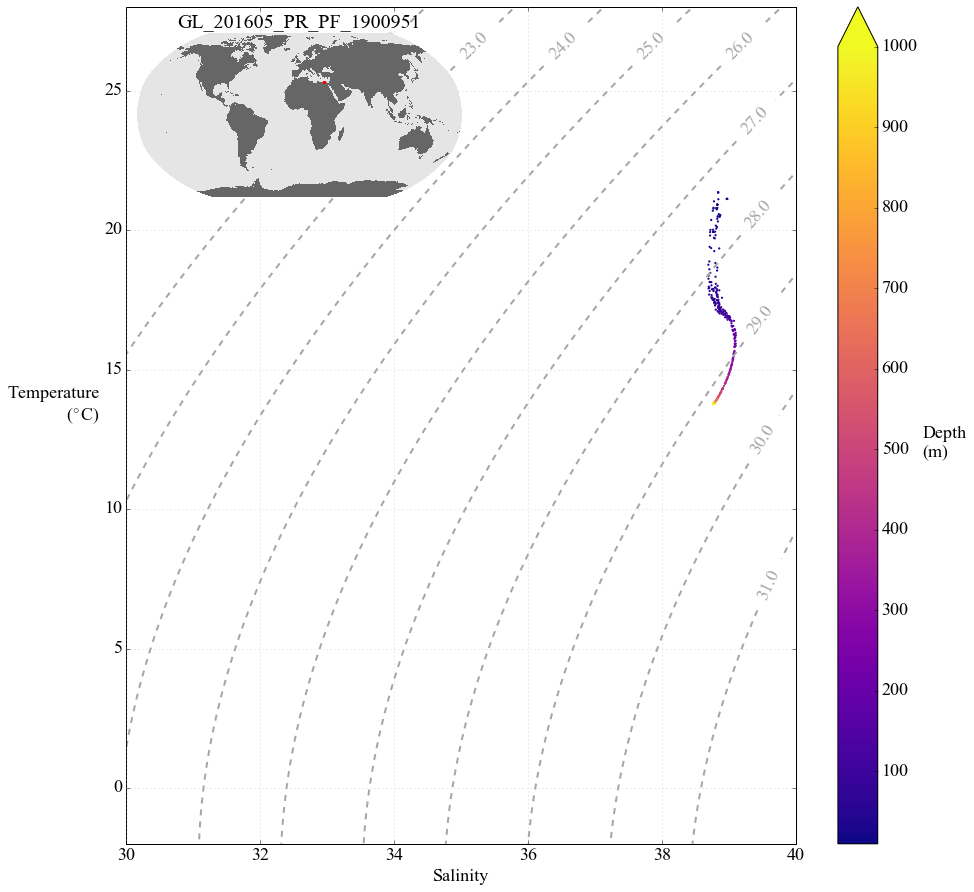

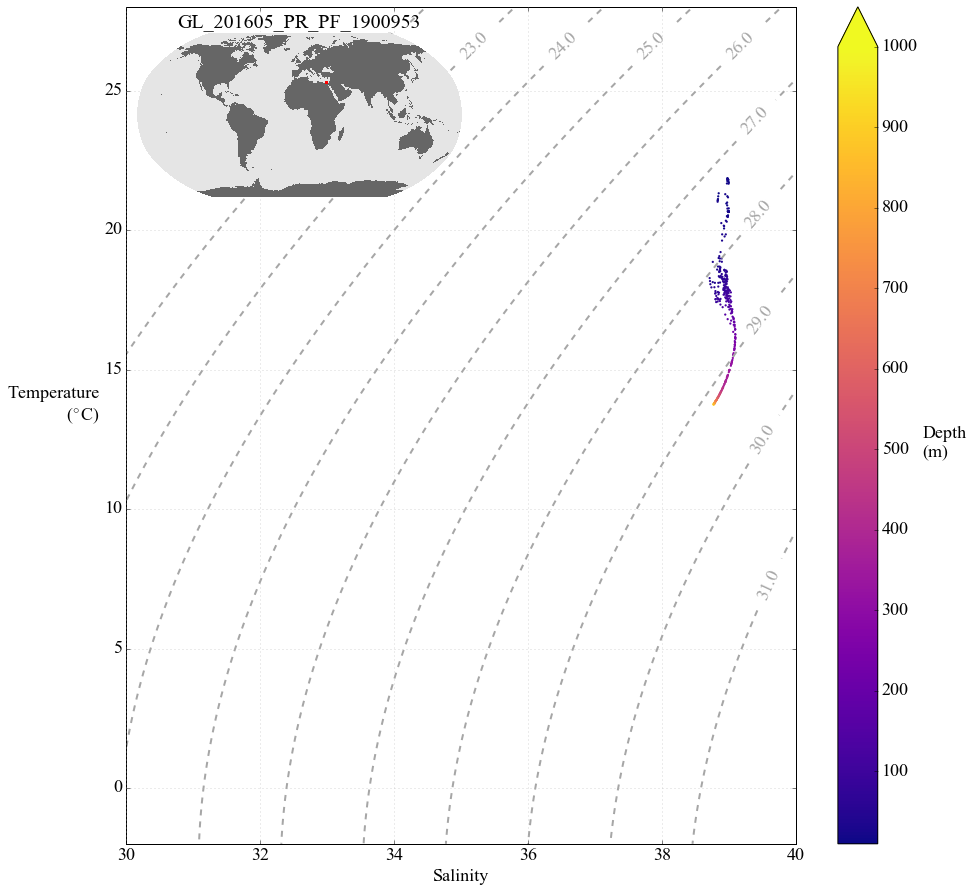

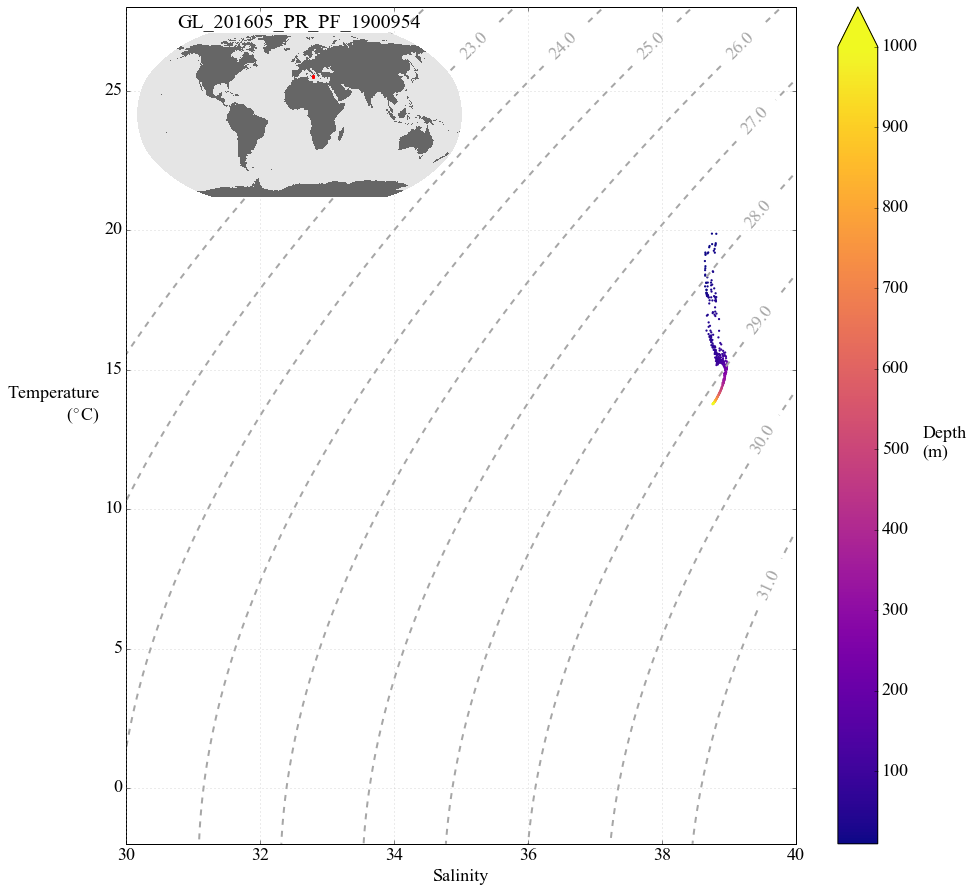

KeyboardInterrupt: 

In [40]:
if not(os.path.exists(figdir)):
    os.mkdir(figdir)
    logger.debug('Create figure directory')
    
datafilelist = sorted(glob.glob(os.path.join(datadir, '*.nc')))
logger.info("Working on {0} files".format(len(datafilelist)))

logger.info('Compute density levels to be added on the plot')
svec, tvec, density = compute_density4plot(tmin, tmax, smin, smax)

# Loop on the files
for datafiles in datafilelist:
    
    figbasename = os.path.basename(datafiles)[:-3]
    logger.info('Working on %s' %(figbasename))
    platformtype = figbasename.split('_')[-2]
    
    # Read the variables from the data file
    logger.info('Reading variables from netCDF file')
    time, time_units, lon, lat, depth, temp, psal = read_variables(datafiles)
    
    # Convert time to dates and change the vector to a 2D array
    #datesarray = convert_time(time, time_units)
    
    # Compute initial and final dates
    #dayinit, dayend = get_init_final_dates(datesarray)
    
    # Apply QC (now included inside the reading function)
    #temp, psal = apply_qc_variables(temp, temp_qc, psal, psal_qc)
    
    # Convert pressure to depth using [Soaunders (1981)] formula
    # --> (now included inside the reading function)
    
    if (np.isnan(psal).all()) or (np.isnan(psal).all()):
        logger.info('No salinity or/and temperature to plot')
    else:
        if temp.shape[0] > 5 and platformtype == 'PF':
            m = Basemap(lon_0=0, projection='robin')
            # T-S diagram

            logger.debug('Temperature shape: {0}'.format(temp.shape))
            logger.info('Creating TS diagram')
            plot_TS(temp, psal, depth, svec, tvec, density, figbasename, m, os.path.join(figdir, figbasename))
        else:
            logger.info('Not enough profiles (< 5)')

In [20]:
figbasename


'MO_201507_PR_XB_LA-SUPREMA'

In [23]:
figbasename.split('_')[-2]

'XB'